# The Autoencoder Framework


Autoencoders are central tools in the recent quest to develop deep learning techniques [Pierre Baldi, 2012, AEs]
to tackle complex tasks such as computer vision, with both minimal need for prior knowledge and human intervention [Bengio and Lecun, Scaling Learning Algorithm for AI].
The autoencoder framework is a parametric, nonlinear unsupervised function between an $n$-dimensional subspace $\mathbb{F}^n$ and itself, which explicitly defines a feature-extracting function in parametric closed form. 
This function is called the encoder $f_{\theta}$ and computes a $p$-dimensional latent representation $z = f(x) \in \mathbb{G}^p$ from an input $x$ from a training set $\mathcal{X} \subseteq \mathbb{F}^n$ [Pierre Baldi]. 
The second part of the autoencoder is another closed form parametric function $g_{\theta}$ called the decoder which maps from the feature space $\mathbb{G}^p$ back the the input space, producing a reconstruction $\tilde{x} = g_{\theta}(z) = (g_{\theta} \circ f_{\theta})(x)$. [Bengio, Representation Learning]. 
Autoencoders are deep architectures, and their parameters $\theta$ are the weights and biases of the network. The weights of the encoder and decoder are learned simultaneously on the reconstruction task to minimise the reconstruction error $\mathcal{L}(x, \tilde{x})$, which is a measure of the discrepancy between an input and its reconstruction.
Hence training an autoencoder consists of finding, for a training set of size $N$
$\mathcal{X} = \{ x^{(t)}: t = 1, \cdots, N\}$,
the weights $\theta$ that minimise the loss [Bengio, Representation Learning]. Hence,
$$\hat{\theta} := \sum_{t = 1}^N\mathcal{L}(x^{(t)}, g_{\theta} (f_{\theta}(x^{(t)}) $$.
To prevent the encoder and the decoder to simply be the identity operations, some additional regularisation is often needed, most commonly in the form of a bottleneck which makes the latent space of a lower dimension than the input space (i.e., $p < n$). This regularisation serves data compression and feature extraction purposes [Bank, Koenigstein, Giryes 2021 - Autoencoders] by ensure that the model learns useful features of the data [Goodfellow, Deep Learning]. As such, most used applications of the autoencoder framework are regularised autoencoders. More generally, any generative model with a representative procedure that computes latent variables can be viewed as a form of autoencoder [Goodfellow, Deep Learning].
Autoencoders are also used in the classification setting as a semi-supervised add-on to the classifer. The encoding function is used as a feature extractor and plugged into the classifier network. The underlying assumption is that similar samples should have similar latent representations, which are encapsulated by the encoding function [Bank, Koenigstein, Giryes]. 

A natural choice for the overall architecture is that of a convolutional autoencoder, where the both the encoder and the decoder are convolutional neural networks. 
One could use deep networks in their stead (with dense layers), although convolutional subnetworks appear to be a more suitable choice for computer vision tasks [O'Shea and Ryan, 205 - Intro to CNN].


## Set up


In [1]:
!pip install ipython-autotime
%load_ext autotime

!pip install image-similarity-measures
!pip install piq
!pip install lpips

!pip install keras-tuner -q

!git clone https://github.com/thelydie/FaceSketchSynthesis.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for phasepack: filename=phasepack-1.5-py3-none-any.whl size=26984 sha256=829072590aaec7c8480c7d7a56c70baa1a94af6f54ec2202ed6a463788467db4
  Stored in directory: /root/.cache/pip/wheels/a0/cd/22/acdeec70f562ae574ad93d9b3254922dddc630e987f6e3c4ff
Successfully built phasepack
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.5/139.5 KB 590.8 kB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://u

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from keras import layers, Model, backend
from keras.optimizers import Adam

from FaceSketchSynthesis import base_models, similarity, preparation

time: 14.5 s (started: 2023-03-09 17:16:53 +00:00)


## Constants

In [3]:
from FaceSketchSynthesis import base_models

TARGET_SIZE = 128,128
IMG_DIM = *TARGET_SIZE,3

# MODELS_PATH='/content/drive/MyDrive/ML Models/'


time: 1.07 ms (started: 2023-03-09 17:17:08 +00:00)


In [4]:
class ModelVizCallback(keras.callbacks.Callback):
    """Callback to display a number of generated outputs"""
    def __init__(self, model, inputs, outputs, target_size, display_count=5, freq=1, **kwargs):
        super(ModelVizCallback, self).__init__(**kwargs)
        self.inputs = inputs[:display_count]
        self.outputs = outputs[:display_count]
        self.model = model
        self.display_count = display_count
        self.target_size = target_size
        self.freq = freq

    def on_epoch_end(self, epoch,logs=None):
        if epoch % self.freq == 0:
            predictions = self.model.predict(self.inputs)
            preparation.plot_synthesis(self.inputs, predictions, self.outputs, self.target_size, n=self.display_count)    

time: 2.99 ms (started: 2023-03-09 17:17:08 +00:00)


## Data

We use the CUHK (with 188 samples) provided by the CUFS. This dataset is comprised of 188 photo-sketch pairs. Each photo is in frontal position with neutral lighting, and the images are cropped to only include the relevant aspects of the picture. We use 150 samples for training and the rest for testing.
Our experiments are gender-agnostics, that is they do not distinguish between male and female faces. 

In our pre-processing, we resize the images to give them a dimension of 128x128 pixels, and we normalise their values to avoid large differences in variance and facilitate training.

Image target size: (128, 128)
Image dimensions: (128, 128, 3)
Training size: 169
Test size: 19


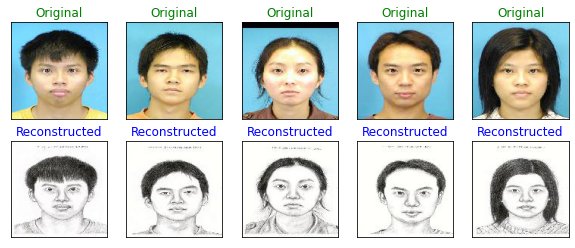

time: 1.89 s (started: 2023-03-09 17:17:08 +00:00)


In [5]:
from sklearn.model_selection import train_test_split

print('Image target size:', TARGET_SIZE)
print('Image dimensions:', IMG_DIM)


CUHK_DATASET = '/content/FaceSketchSynthesis/datasets/cuhk_dataset'

cuhk_photo_train = preparation.load_dataset(CUHK_DATASET+'/photos_train', TARGET_SIZE)
cuhk_sketch_train = preparation.load_dataset(CUHK_DATASET+'/sketches_train', TARGET_SIZE)
cuhk_photo_test = preparation.load_dataset(CUHK_DATASET+'/photos_test', TARGET_SIZE)
cuhk_sketch_test = preparation.load_dataset(CUHK_DATASET+'/sketches_test', TARGET_SIZE)

# print('\nDataset size is', cuhk_photos.shape)
train_size = cuhk_photo_train.shape[0]
test_size = cuhk_photo_test.shape[0]
print('Training size:', train_size)
print('Test size:', test_size)

preparation.plot_side_by_side(cuhk_photo_test, cuhk_sketch_test, TARGET_SIZE, n=5)

In [6]:
import os

# Name template: img-01-model
def create_image_filename(img_no, model_name):
    # Names include: photo, ae-mse, ae-ssim, vae-mse, vae-ssim, wtae, 
    return f'img-{img_no :03d}-{model_name}.jpg'

EVALUATION_IMG_DIR = '/content/drive/MyDrive/evaluation_results/'

def save_images(images, model_name, dir=EVALUATION_IMG_DIR):
    n = len(images)
    for i in range(n):
        img_array = images[i]
        filepath = os.path.join(dir, create_image_filename(i+1, model_name))
        keras.preprocessing.image.save_img(filepath, img_array)

# save_images(cuhk_photo_train[:1], EVALUATION_IMG_DIR, 'test')

time: 1.98 ms (started: 2023-03-09 17:17:10 +00:00)


# Architecure

In [7]:
def get_autoencoder(model_name:str = 'autoencoder'):
    # Inputs

    input_img = layers.Input(shape=IMG_DIM, name='input_image')

    # Encoder
    x = base_models.convolutionStack(input_img, 32, activation=layers.LeakyReLU(0.2), 
                                    kernel_size=3, use_bn=False, strides=2)
    x = base_models.convolutionStack(x, 32, activation=layers.LeakyReLU(0.2), 
                                    kernel_size=3, use_bn=False, strides=1)
    latent_inputs = base_models.convolutionStack(x, 16, activation=layers.LeakyReLU(0.2), 
                                    kernel_size=3, strides=2)
    encoder = Model(input_img, latent_inputs)

    latent_inputs_shape = latent_inputs.shape[1:]

    # Decoder
    latent_x = layers.Input(shape=latent_inputs_shape)
    x = layers.UpSampling2D(size=2, interpolation='bilinear')(latent_x)
    x = base_models.convolutionStack(x, 32, activation=layers.LeakyReLU(0.2), 
                                    kernel_size=3, use_bn=False, strides=1)
    x = base_models.convolutionStack(x, 16, activation=layers.LeakyReLU(0.2), 
                                    kernel_size=3, use_bn=True, strides=1)
    x = layers.UpSampling2D(size=2, interpolation='lanczos5')(x)
    x = layers.Conv2D(3, kernel_size=3, strides=1, padding='same', 
                      activation='sigmoid', name='decoded_output')(x)
    decoder = Model(latent_x, x)
    # autoencoder = Model(input_img, x, name=model_name)
    autoencoder = base_models.Autoencoder(encoder,decoder, name=model_name)

    return autoencoder



time: 4.24 ms (started: 2023-03-09 17:17:10 +00:00)


# Sketch Reconstruction

Let us use the autoencoder in the unsupervised setting first. We train an autencoder to get reconstruct a sketch image.

In [ ]:
sketch_autoencoder = get_autoencoder('sketch_autoencoder')

sketch_autoencoder.compile(
    optimizer = keras.optimizers.Adam(0.005),
    loss = keras.losses.mse
)

sketch_autoencoder.build((None,*IMG_DIM))
sketch_autoencoder.summary()

Model: "sketch_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 32, 32, 16)        14768     
                                                                 
 model_1 (Functional)        (None, 128, 128, 3)       9763      
                                                                 
Total params: 24,531
Trainable params: 24,499
Non-trainable params: 32
_________________________________________________________________
time: 567 ms (started: 2023-03-07 17:39:56 +00:00)


## Model Training

In [ ]:
sketch_autoencoder.fit(cuhk_sketch_train, cuhk_sketch_train,
                 epochs=100, batch_size=32, 
                 validation_split=0.15)

# sketch_autoencoder.save(f'{MODELS_PATH}sketch_autoencoder')


Epoch 1/100
5/5 [==============================] - 15s 3s/step - loss: 0.1207 - val_loss: 0.0948
Epoch 2/100
5/5 [==============================] - 14s 3s/step - loss: 0.0337 - val_loss: 0.1074
Epoch 3/100
5/5 [==============================] - 8s 2s/step - loss: 0.0167 - val_loss: 0.1074
Epoch 4/100
5/5 [==============================] - 7s 1s/step - loss: 0.0125 - val_loss: 0.1071
Epoch 5/100
5/5 [==============================] - 8s 2s/step - loss: 0.0116 - val_loss: 0.1066
Epoch 6/100
5/5 [==============================] - 7s 1s/step - loss: 0.0104 - val_loss: 0.1062
Epoch 7/100
5/5 [==============================] - 8s 2s/step - loss: 0.0101 - val_loss: 0.1053
Epoch 8/100
5/5 [==============================] - 8s 2s/step - loss: 0.0094 - val_loss: 0.1018
Epoch 9/100
5/5 [==============================] - 7s 1s/step - loss: 0.0097 - val_loss: 0.0915
Epoch 10/100
5/5 [==============================] - 8s 2s/step - loss: 0.0086 - val_loss: 0.0754
Epoch 11/100
5/5 [===================

time: 13min 26s (started: 2023-03-07 17:39:56 +00:00)


## Model Recovery

In [ ]:
sketch_autoencoder = keras.models.load_model(f'{MODELS_PATH}model2_s2s')
sketch_autoencoder.build((None, *IMG_DIM))
sketch_autoencoder.summary()

## Model Evaluation

1/1 [==============================] - 0s 412ms/step


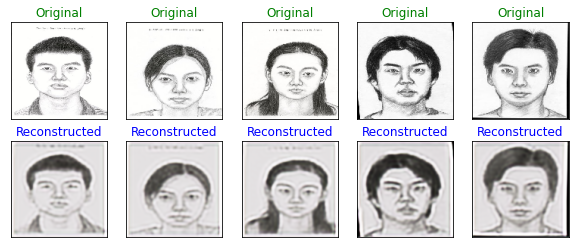

time: 952 ms (started: 2023-03-07 17:53:39 +00:00)


In [ ]:
reconstructed_sketches = sketch_autoencoder.predict(cuhk_sketch_test)
preparation.plot_side_by_side(cuhk_sketch_test, reconstructed_sketches, TARGET_SIZE)

/usr/local/lib/python3.8/dist-packages/image_similarity_measures/quality_metrics.py:197: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return structural_similarity(org_img, pred_img, data_range=max_p, multichannel=True)


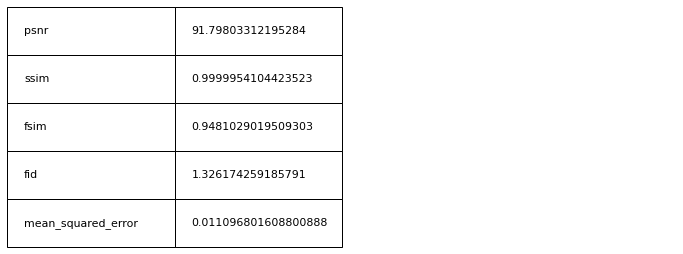

time: 7.73 s (started: 2023-03-07 17:53:55 +00:00)


In [ ]:
evaluator_sk = similarity.Evaluator('sketch_reconstruction')

for measure_name in similarity.PRE_LOADED_MEASURES:
  evaluator_sk.evaluate_batch(cuhk_sketch_test,reconstructed_sketches, measure_name)
evaluator_sk.results

preparation.plot_results(evaluator_sk.results)

# Face Reconstruction

Let us use the autoencoder in the unsupervised setting. We train an autencoder to get reconstruct a sketch image.

In [ ]:
face_autoencoder = get_autoencoder('face_autoencoder')

face_autoencoder.compile(
    optimizer = keras.optimizers.Adam(0.005),
    loss = keras.losses.mse
)

time: 363 ms (started: 2023-03-07 17:54:16 +00:00)


## Model Training

In [ ]:
face_autoencoder.fit(cuhk_photo_train, cuhk_photo_train,
                 epochs=100, batch_size=32, 
                 validation_split=0.15)

face_autoencoder.save(f'{MODELS_PATH}face_autoencoder')


Epoch 1/100
5/5 [==============================] - 9s 1s/step - loss: 0.0596 - val_loss: 0.0731
Epoch 2/100
5/5 [==============================] - 8s 2s/step - loss: 0.0158 - val_loss: 0.0618
Epoch 3/100
5/5 [==============================] - 7s 1s/step - loss: 0.0117 - val_loss: 0.0644
Epoch 4/100
5/5 [==============================] - 8s 1s/step - loss: 0.0100 - val_loss: 0.0664
Epoch 5/100
5/5 [==============================] - 8s 2s/step - loss: 0.0084 - val_loss: 0.0469
Epoch 6/100
5/5 [==============================] - 7s 1s/step - loss: 0.0079 - val_loss: 0.0498
Epoch 7/100
5/5 [==============================] - 9s 2s/step - loss: 0.0070 - val_loss: 0.0408
Epoch 8/100
5/5 [==============================] - 7s 1s/step - loss: 0.0064 - val_loss: 0.0383
Epoch 9/100
5/5 [==============================] - 8s 2s/step - loss: 0.0057 - val_loss: 0.0229
Epoch 10/100
5/5 [==============================] - 7s 1s/step - loss: 0.0055 - val_loss: 0.0250
Epoch 11/100
5/5 [=====================

time: 13min 27s (started: 2023-03-07 17:54:26 +00:00)


## Model Recovery

In [ ]:
face_autoencoder = keras.models.load_model(f'{MODELS_PATH}face_autoencoder')
face_autoencoder.build((None, *IMG_DIM))
face_autoencoder.summary()

## Model Evaluation

1/1 [==============================] - 1s 654ms/step


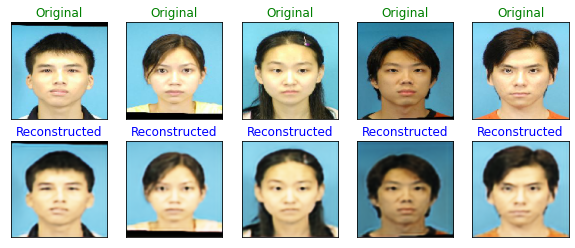

time: 1.67 s (started: 2023-03-07 18:07:53 +00:00)


In [ ]:
reconstructed_faces = face_autoencoder.predict(cuhk_photo_test)
preparation.plot_side_by_side(cuhk_photo_test, reconstructed_faces, TARGET_SIZE)

/usr/local/lib/python3.8/dist-packages/image_similarity_measures/quality_metrics.py:197: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return structural_similarity(org_img, pred_img, data_range=max_p, multichannel=True)


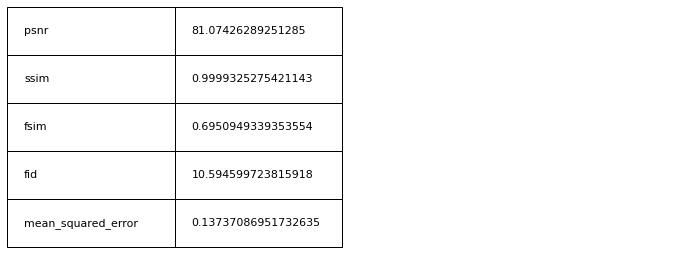

time: 6.55 s (started: 2023-03-07 18:07:54 +00:00)


In [ ]:
evaluator_sk = similarity.Evaluator('face_reconstruction')
for measure_name in similarity.PRE_LOADED_MEASURES:
  evaluator_sk.evaluate_batch(cuhk_sketch_test,reconstructed_faces, measure_name)
evaluator_sk.results
preparation.plot_results(evaluator_sk.results)


## Face Reconstruction using SSIMLoss



In [ ]:
face_autoencoder_ssim = get_autoencoder('face_autoencoder')

face_autoencoder_ssim.compile(
    optimizer = keras.optimizers.Adam(0.005),
    loss = keras.losses.SSIMLoss
)

face_autoencoder_ssim.fit(cuhk_photo_train, cuhk_photo_train,
                 epochs=100, batch_size=32, 
                 validation_split=0.15)

face_autoencoder.save(f'{MODELS_PATH}face_autoencoder')

time: 363 ms (started: 2023-03-07 17:54:16 +00:00)


In [ ]:
face_autoencoder.fit(cuhk_photo_train, cuhk_photo_train,
                 epochs=100, batch_size=32, 
                 validation_split=0.15)

face_autoencoder.save(f'{MODELS_PATH}face_autoencoder')


Epoch 1/100
5/5 [==============================] - 9s 1s/step - loss: 0.0596 - val_loss: 0.0731
Epoch 2/100
5/5 [==============================] - 8s 2s/step - loss: 0.0158 - val_loss: 0.0618
Epoch 3/100
5/5 [==============================] - 7s 1s/step - loss: 0.0117 - val_loss: 0.0644
Epoch 4/100
5/5 [==============================] - 8s 1s/step - loss: 0.0100 - val_loss: 0.0664
Epoch 5/100
5/5 [==============================] - 8s 2s/step - loss: 0.0084 - val_loss: 0.0469
Epoch 6/100
5/5 [==============================] - 7s 1s/step - loss: 0.0079 - val_loss: 0.0498
Epoch 7/100
5/5 [==============================] - 9s 2s/step - loss: 0.0070 - val_loss: 0.0408
Epoch 8/100
5/5 [==============================] - 7s 1s/step - loss: 0.0064 - val_loss: 0.0383
Epoch 9/100
5/5 [==============================] - 8s 2s/step - loss: 0.0057 - val_loss: 0.0229
Epoch 10/100
5/5 [==============================] - 7s 1s/step - loss: 0.0055 - val_loss: 0.0250
Epoch 11/100
5/5 [=====================

time: 13min 27s (started: 2023-03-07 17:54:26 +00:00)


1/1 [==============================] - 1s 654ms/step


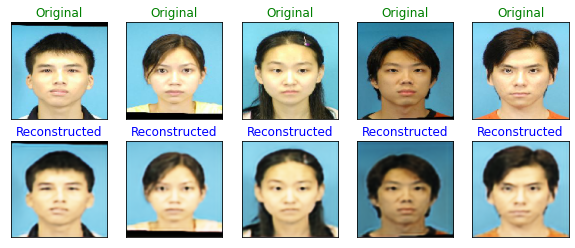

time: 1.67 s (started: 2023-03-07 18:07:53 +00:00)


In [ ]:
reconstructed_faces = face_autoencoder.predict(cuhk_photo_test)
preparation.plot_side_by_side(cuhk_photo_test, reconstructed_faces, TARGET_SIZE)

/usr/local/lib/python3.8/dist-packages/image_similarity_measures/quality_metrics.py:197: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return structural_similarity(org_img, pred_img, data_range=max_p, multichannel=True)


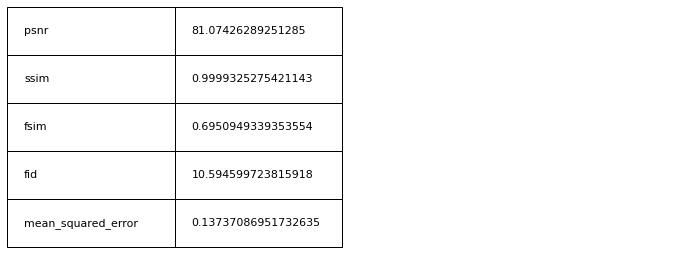

time: 6.55 s (started: 2023-03-07 18:07:54 +00:00)


In [ ]:
evaluator_sk = similarity.Evaluator('face_reconstruction')
for measure_name in similarity.PRE_LOADED_MEASURES:
  evaluator_sk.evaluate_batch(cuhk_sketch_test,reconstructed_faces, measure_name)
evaluator_sk.results
preparation.plot_results(evaluator_sk.results)


# Sketch Synthesis I - Direct Approach

Our first attempt at generating sketches from faces is a direct one. We assume, as before, that the outputs (sketches) are produced from a latent (hidden) code z via a decoder model. We now prepend this decoder by a network that learns this code $z$ from an input (face), and both networks are trained simultaneously.

## DAE-MSE

### Model Training

In [ ]:
sketch_synth_direct = get_autoencoder(model_name = 'sketch_synthesis_direct')
sketch_synth_direct_eval = similarity.Evaluator('model1_f2s')

sketch_synth_direct.compile(
    optimizer = keras.optimizers.Adam(0.0056),
    loss = keras.losses.mse
)

time: 540 ms (started: 2023-03-08 22:37:02 +00:00)


Epoch 1/200
6/6 [==============================] - 11s 1s/step - loss: 0.1270 - val_loss: 0.0700
Epoch 2/200
6/6 [==============================] - 10s 2s/step - loss: 0.0618 - val_loss: 0.0958
Epoch 3/200
6/6 [==============================] - 13s 2s/step - loss: 0.0534 - val_loss: 0.0981
Epoch 4/200
6/6 [==============================] - 11s 2s/step - loss: 0.0493 - val_loss: 0.0968
Epoch 5/200
6/6 [==============================] - 10s 1s/step - loss: 0.0469 - val_loss: 0.0959
Epoch 6/200
6/6 [==============================] - 12s 2s/step - loss: 0.0453 - val_loss: 0.0982
Epoch 7/200
6/6 [==============================] - 9s 2s/step - loss: 0.0452 - val_loss: 0.0990
Epoch 8/200
6/6 [==============================] - 10s 2s/step - loss: 0.0458 - val_loss: 0.0990
Epoch 9/200
6/6 [==============================] - 22s 4s/step - loss: 0.0452 - val_loss: 0.0988
Epoch 10/200
6/6 [==============================] - 19s 3s/step - loss: 0.0449 - val_loss: 0.0940
Epoch 11/200
6/6 [============

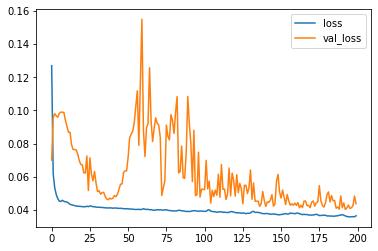

time: 35min 50s (started: 2023-03-08 22:37:03 +00:00)


In [ ]:
sketch_synth_direct.fit(
    cuhk_photo_train, cuhk_sketch_train,
    validation_data = (cuhk_photo_test, cuhk_sketch_test),
    epochs = 200, shuffle=False,
    batch_size = 32
)

sketch_synth_direct.save(f'{MODELS_PATH}sketch_synthesis_direct')

plt.plot(sketch_synth_direct.history.history["loss"])
plt.plot(sketch_synth_direct.history.history["val_loss"])
plt.legend(['loss', 'val_loss'], loc='upper right')

### Model Recovery

In [ ]:
sketch_synth_direct = keras.models.load_model(f'{MODELS_PATH}sketch_synthesis_direct')

time: 1.26 s (started: 2023-03-08 23:12:54 +00:00)


### Model Evaluation

1/1 [==============================] - 1s 644ms/step


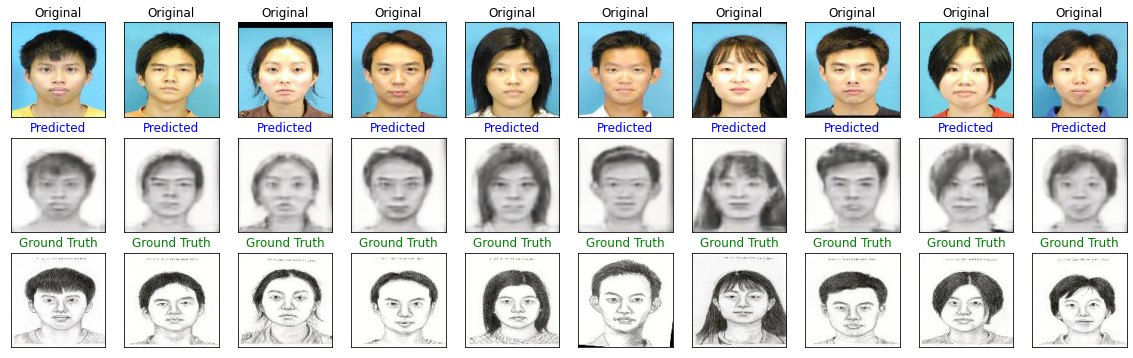

time: 2.15 s (started: 2023-03-08 23:12:55 +00:00)


In [ ]:
generated_sketches = sketch_synth_direct.predict(cuhk_photo_test)
preparation.plot_synthesis(cuhk_photo_test, generated_sketches, cuhk_sketch_test, target_size=TARGET_SIZE, n=10)

# Save the images 
save_images(generated_sketches, model_name='ae_mse')

/usr/local/lib/python3.9/dist-packages/image_similarity_measures/quality_metrics.py:197: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return structural_similarity(org_img, pred_img, data_range=max_p, multichannel=True)


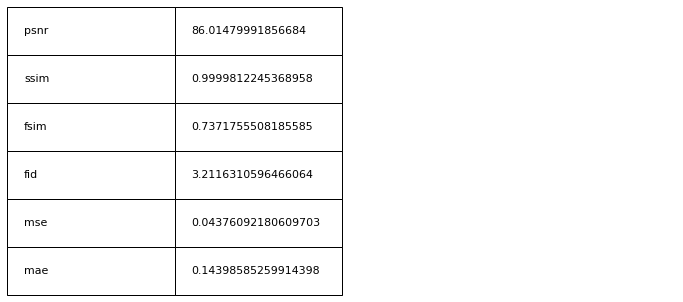

time: 8.3 s (started: 2023-03-08 23:12:57 +00:00)


In [ ]:
evaluator_sk = similarity.Evaluator('direct_face_to_sketch')
evaluator_sk.evaluate_batch_on_all(cuhk_sketch_test,generated_sketches)
preparation.plot_dict_as_table(evaluator_sk.results)

## DAE-SSIM

### Model Training

In [8]:
sketch_synth_direct_ssim = get_autoencoder(model_name = 'sketch_synthesis_direct_ssim')
sketch_synth_direct_ssim_eval = similarity.Evaluator('f2s_direct_ssim')

sketch_synth_direct_ssim.compile(
    optimizer = keras.optimizers.Adam(0.0056),
    loss = base_models.SSIMLoss()
)

time: 544 ms (started: 2023-03-09 17:17:10 +00:00)


In [ ]:
sketch_synth_direct_ssim.fit(
    cuhk_photo_train, cuhk_sketch_train,
    validation_split = 0.1,
    epochs = 100, shuffle=False,
    batch_size = 32
)

sketch_synth_direct_ssim.save(f'{MODELS_PATH}sketch_synthesis_direct-ssim')

plt.plot(sketch_synth_direct_ssim.history.history["loss"])
plt.plot(sketch_synth_direct_ssim.history.history["val_loss"])
plt.legend(['loss', 'val_loss'], loc='upper right')

Epoch 1/100
5/5 [==============================] - 54s 10s/step - loss: 0.6662 - val_loss: 0.5806
Epoch 2/100
5/5 [==============================] - 33s 7s/step - loss: 0.6052 - val_loss: 0.5852
Epoch 3/100
5/5 [==============================] - 34s 7s/step - loss: 0.5751 - val_loss: 0.5917
Epoch 4/100
5/5 [==============================] - 32s 6s/step - loss: 0.5538 - val_loss: 0.5916
Epoch 5/100
5/5 [==============================] - 34s 7s/step - loss: 0.5398 - val_loss: 0.5884
Epoch 6/100
5/5 [==============================] - 32s 7s/step - loss: 0.5314 - val_loss: 0.5884
Epoch 7/100
5/5 [==============================] - 32s 7s/step - loss: 0.5250 - val_loss: 0.5892
Epoch 8/100
5/5 [==============================] - 32s 6s/step - loss: 0.5332 - val_loss: 0.5905
Epoch 9/100
5/5 [==============================] - 36s 7s/step - loss: 0.5398 - val_loss: 0.5902
Epoch 10/100
5/5 [==============================] - 32s 7s/step - loss: 0.5332 - val_loss: 0.5926
Epoch 11/100
5/5 [==========

### Model Recovery

In [ ]:
sketch_synth_direct_ssim = keras.models.load_model(f'{MODELS_PATH}sketch_synthesis_direct')

### Model Evaluation

1/1 [==============================] - 1s 602ms/step


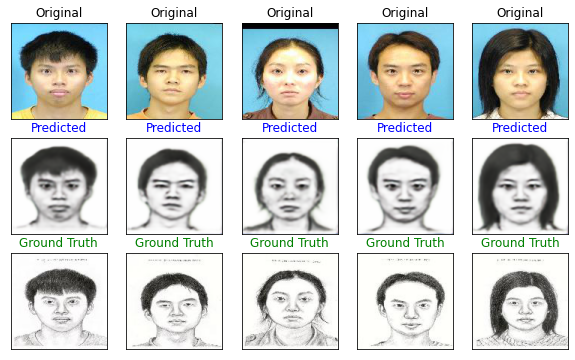

time: 1.93 s (started: 2023-03-09 18:16:30 +00:00)


In [10]:
generated_sketches = sketch_synth_direct_ssim.predict(cuhk_photo_test)
preparation.plot_synthesis(cuhk_photo_test, generated_sketches, cuhk_sketch_test, target_size=TARGET_SIZE)
save_images(generated_sketches, 'ae_ssim')

{'psnr': 84.61187937128226, 'ssim': 0.9999661445617676, 'fsim': 0.7220579848880574, 'fid': 4.147418975830078, 'mse': 0.07113229483366013, 'mae': 0.15619851648807526}


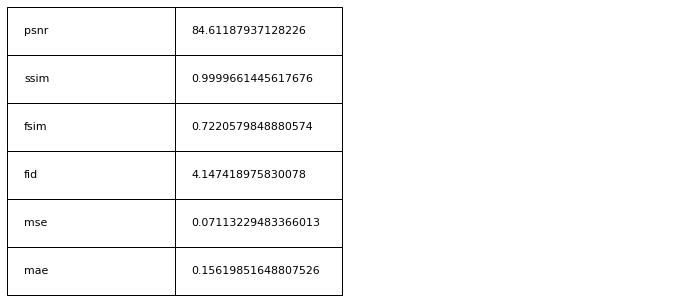

time: 179 ms (started: 2023-03-09 18:17:53 +00:00)


In [13]:
evaluator_sk = similarity.Evaluator('direct_face_to_sketch')
evaluator_sk.evaluate_batch_on_all(cuhk_sketch_test,generated_sketches)
print(evaluator_sk.results)
preparation.plot_dict_as_table(evaluator_sk.results)

# Sketch Synthesis II - Weight Transfer Learning 

Our second attempt consists of using transfer learning with the sketch autoencoder. The intuition is that the autoencoder's decoder is already trained to decode some latent inputs to a sketch, and we can utilise this decoder as part of a larger model. We prepend the decoder with an encoder-type network. The difference between the two approaches is that the new model uses already trained layers as its starting layers. Only the new layers need to be trained.

We train it in two stages:
1. Train the new layers only. This is equivalent to training the encoder to learn a latent representation z.
2. Fine tune the model, by re-training all layers with a low learning rate

In [ ]:
sketch_autoencoder = keras.models.load_model(f'{MODELS_PATH}sketch_autoencoder')

# Freeze the model
sketch_autoencoder.trainable = False

input_img = layers.Input(shape=IMG_DIM, name='input_image')

# Encode the image to a latent code for a sketch
x = base_models.convolutionStack(input_img, 32, activation=layers.LeakyReLU(0.2), 
                                kernel_size=3, use_bn=False, strides=2)
x = base_models.convolutionStack(x, 32, activation=layers.LeakyReLU(0.2), 
                                kernel_size=3, use_bn=False, strides=1)
x = base_models.convolutionStack(x, 16, activation=layers.LeakyReLU(0.1), kernel_size=3)
latent_inputs = base_models.convolutionStack(x, 16, activation=layers.LeakyReLU(0.2), 
                                kernel_size=3, strides=2)

# Now decode the representation to a sketch
output_img = sketch_autoencoder.decoder(latent_inputs)

# Define the transferae and an evaluator object
transfer_ae = Model(input_img, output_img, name='model2_transfer_f2s')
transfer_ae_eval = similarity.Evaluator('face_to_sketch_transfer')

transfer_ae.compile(
    keras.optimizers.Adam(0.003),
    keras.losses.mse
)

transfer_ae.summary()

Model: "model2_transfer_f2s"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 64, 64, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 64, 64, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 16)        4624      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 64, 64, 16)

## Initial Model Training

Initially, we train the new model for 100 epochs, with the decoder frozen. We only effectively train the new layers

Epoch 1/100
1/1 [==============================] - 0s 203ms/step


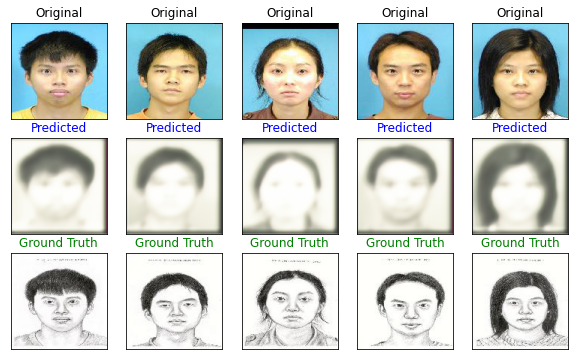

6/6 [==============================] - 12s 2s/step - loss: 0.3487 - val_loss: 0.0766
Epoch 2/100
6/6 [==============================] - 10s 2s/step - loss: 0.0833 - val_loss: 0.0976
Epoch 3/100
6/6 [==============================] - 7s 1s/step - loss: 0.1048 - val_loss: 0.0988
Epoch 4/100
6/6 [==============================] - 9s 2s/step - loss: 0.1058 - val_loss: 0.0982
Epoch 5/100
6/6 [==============================] - 7s 1s/step - loss: 0.1010 - val_loss: 0.0781
Epoch 6/100
6/6 [==============================] - 9s 2s/step - loss: 0.0850 - val_loss: 0.0903
Epoch 7/100
6/6 [==============================] - 7s 1s/step - loss: 0.0990 - val_loss: 0.0970
Epoch 8/100
6/6 [==============================] - 9s 1s/step - loss: 0.1026 - val_loss: 0.0962
Epoch 9/100
6/6 [==============================] - 8s 1s/step - loss: 0.0986 - val_loss: 0.0899
Epoch 10/100
6/6 [==============================] - 8s 1s/step - loss: 0.0790 - val_loss: 0.0708
Epoch 11/100
6/6 [==============================]

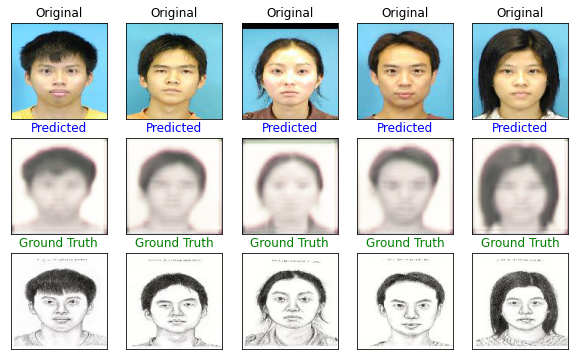

6/6 [==============================] - 8s 1s/step - loss: 0.0457 - val_loss: 0.0495
Epoch 22/100
6/6 [==============================] - 9s 1s/step - loss: 0.0452 - val_loss: 0.0493
Epoch 23/100
6/6 [==============================] - 8s 1s/step - loss: 0.0449 - val_loss: 0.0495
Epoch 24/100
6/6 [==============================] - 8s 1s/step - loss: 0.0446 - val_loss: 0.0501
Epoch 25/100
6/6 [==============================] - 9s 2s/step - loss: 0.0449 - val_loss: 0.0488
Epoch 26/100
6/6 [==============================] - 7s 1s/step - loss: 0.0443 - val_loss: 0.0486
Epoch 27/100
6/6 [==============================] - 9s 2s/step - loss: 0.0443 - val_loss: 0.0483
Epoch 28/100
6/6 [==============================] - 7s 1s/step - loss: 0.0442 - val_loss: 0.0483
Epoch 29/100
6/6 [==============================] - 9s 2s/step - loss: 0.0438 - val_loss: 0.0482
Epoch 30/100
6/6 [==============================] - 7s 1s/step - loss: 0.0440 - val_loss: 0.0479
Epoch 31/100
6/6 [=========================

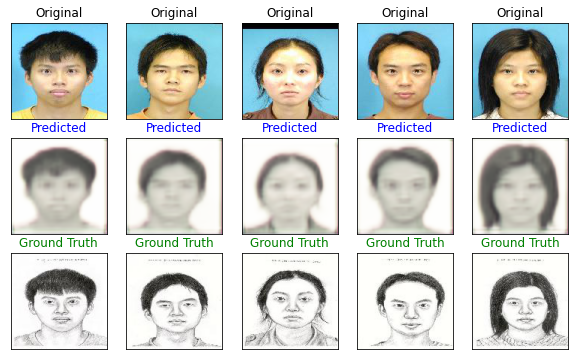

6/6 [==============================] - 10s 2s/step - loss: 0.0443 - val_loss: 0.0493
Epoch 42/100
6/6 [==============================] - 7s 1s/step - loss: 0.0438 - val_loss: 0.0491
Epoch 43/100
6/6 [==============================] - 9s 2s/step - loss: 0.0445 - val_loss: 0.0486
Epoch 44/100
6/6 [==============================] - 7s 1s/step - loss: 0.0436 - val_loss: 0.0476
Epoch 45/100
6/6 [==============================] - 9s 1s/step - loss: 0.0428 - val_loss: 0.0474
Epoch 46/100
6/6 [==============================] - 8s 1s/step - loss: 0.0427 - val_loss: 0.0474
Epoch 47/100
6/6 [==============================] - 9s 1s/step - loss: 0.0425 - val_loss: 0.0471
Epoch 48/100
6/6 [==============================] - 9s 2s/step - loss: 0.0424 - val_loss: 0.0471
Epoch 49/100
6/6 [==============================] - 7s 1s/step - loss: 0.0424 - val_loss: 0.0471
Epoch 50/100
6/6 [==============================] - 9s 2s/step - loss: 0.0425 - val_loss: 0.0474
Epoch 51/100
6/6 [========================

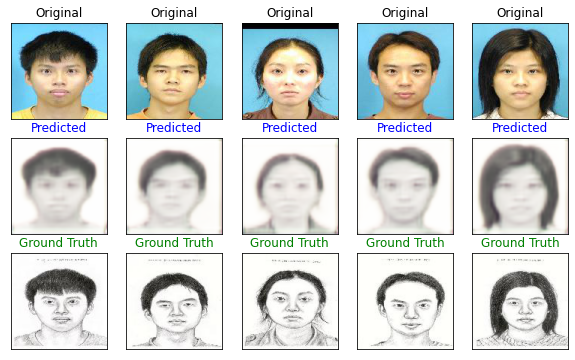

6/6 [==============================] - 10s 1s/step - loss: 0.0421 - val_loss: 0.0469
Epoch 62/100
6/6 [==============================] - 9s 2s/step - loss: 0.0422 - val_loss: 0.0470
Epoch 63/100
6/6 [==============================] - 7s 1s/step - loss: 0.0422 - val_loss: 0.0467
Epoch 64/100
6/6 [==============================] - 9s 2s/step - loss: 0.0421 - val_loss: 0.0465
Epoch 65/100
6/6 [==============================] - 7s 1s/step - loss: 0.0420 - val_loss: 0.0464
Epoch 66/100
6/6 [==============================] - 9s 2s/step - loss: 0.0418 - val_loss: 0.0470
Epoch 67/100
6/6 [==============================] - 8s 1s/step - loss: 0.0420 - val_loss: 0.0466
Epoch 68/100
6/6 [==============================] - 9s 1s/step - loss: 0.0418 - val_loss: 0.0465
Epoch 69/100
6/6 [==============================] - 9s 2s/step - loss: 0.0417 - val_loss: 0.0468
Epoch 70/100
6/6 [==============================] - 8s 1s/step - loss: 0.0418 - val_loss: 0.0467
Epoch 71/100
6/6 [========================

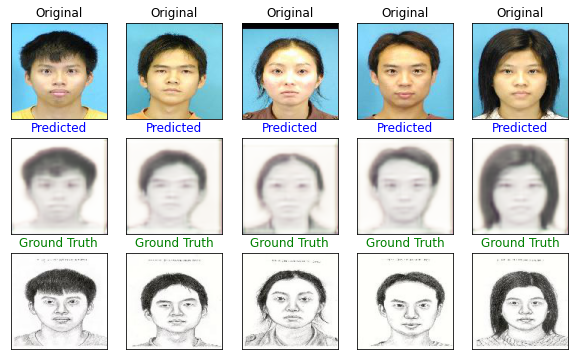

6/6 [==============================] - 9s 1s/step - loss: 0.0417 - val_loss: 0.0469
Epoch 82/100
6/6 [==============================] - 9s 1s/step - loss: 0.0417 - val_loss: 0.0475
Epoch 83/100
6/6 [==============================] - 9s 2s/step - loss: 0.0423 - val_loss: 0.0464
Epoch 84/100
6/6 [==============================] - 7s 1s/step - loss: 0.0419 - val_loss: 0.0467
Epoch 85/100
6/6 [==============================] - 10s 2s/step - loss: 0.0416 - val_loss: 0.0467
Epoch 86/100
6/6 [==============================] - 7s 1s/step - loss: 0.0415 - val_loss: 0.0497
Epoch 87/100
6/6 [==============================] - 9s 2s/step - loss: 0.0429 - val_loss: 0.0466
Epoch 88/100
6/6 [==============================] - 7s 1s/step - loss: 0.0422 - val_loss: 0.0464
Epoch 89/100
6/6 [==============================] - 9s 1s/step - loss: 0.0423 - val_loss: 0.0481
Epoch 90/100
6/6 [==============================] - 8s 1s/step - loss: 0.0424 - val_loss: 0.0464
Epoch 91/100
6/6 [========================

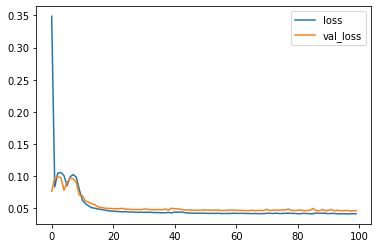

time: 14min 23s (started: 2023-03-08 23:13:12 +00:00)


In [ ]:
transfer_ae.fit(
    cuhk_photo_train, cuhk_sketch_train,
    batch_size=32, epochs=100, 
    validation_data=(cuhk_photo_test, cuhk_sketch_test),
    callbacks=[
        ModelVizCallback(transfer_ae, cuhk_photo_test, cuhk_sketch_test, TARGET_SIZE, freq=20)
    ]
)

plt.plot(transfer_ae.history.history["loss"])
plt.plot(transfer_ae.history.history["val_loss"])
plt.legend(['loss', 'val_loss'], loc='upper right')


1/1 [==============================] - 0s 306ms/step


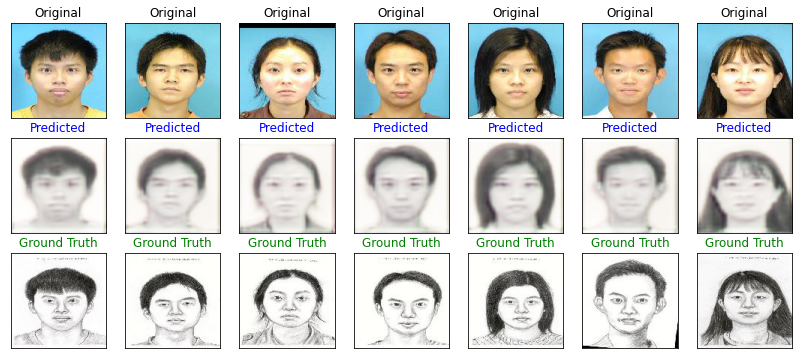

Mean FID over the test samples: 6.8766770362854
time: 2.09 s (started: 2023-03-08 23:27:35 +00:00)


In [ ]:
generated_sketches = transfer_ae.predict(cuhk_photo_test)
preparation.plot_synthesis(cuhk_photo_test, generated_sketches, cuhk_sketch_test, TARGET_SIZE, n=7)

# Evaluate with the FID index
fid_index = transfer_ae_eval.evaluate_batch(cuhk_photo_test, generated_sketches, 'fid')
print('Mean FID over the test samples:', fid_index)

## Fine Tuning the model

The final step is **fine-tuning** the model. It consists of unfreezing part of (or all) the layers and retrain the model on a very low learning rate.

Epoch 1/20
6/6 [==============================] - 12s 1s/step - loss: 0.0591 - val_loss: 0.0468
Epoch 2/20
6/6 [==============================] - 11s 2s/step - loss: 0.0589 - val_loss: 0.0476
Epoch 3/20
6/6 [==============================] - 11s 2s/step - loss: 0.0589 - val_loss: 0.0485
Epoch 4/20
6/6 [==============================] - 9s 1s/step - loss: 0.0587 - val_loss: 0.0495
Epoch 5/20
6/6 [==============================] - 11s 2s/step - loss: 0.0588 - val_loss: 0.0506
Epoch 6/20
6/6 [==============================] - 11s 2s/step - loss: 0.0586 - val_loss: 0.0517
Epoch 7/20
6/6 [==============================] - 9s 2s/step - loss: 0.0586 - val_loss: 0.0529
Epoch 8/20
6/6 [==============================] - 11s 2s/step - loss: 0.0586 - val_loss: 0.0540
Epoch 9/20
6/6 [==============================] - 11s 2s/step - loss: 0.0585 - val_loss: 0.0552
Epoch 10/20
6/6 [==============================] - 10s 2s/step - loss: 0.0584 - val_loss: 0.0563
Epoch 11/20
6/6 [========================

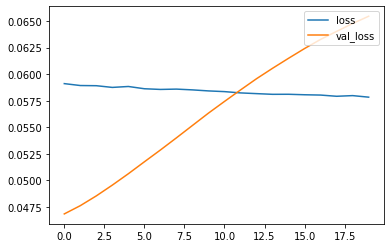

time: 4min 24s (started: 2023-03-08 23:27:37 +00:00)


In [ ]:
# Unfreeze all layers
transfer_ae.trainable = True

transfer_ae.compile(
    keras.optimizers.Adam(0.000001),
    keras.losses.mse,
)
transfer_ae.fit(
    cuhk_photo_train, cuhk_sketch_train,
    batch_size=32, epochs=20, 
    validation_data=(cuhk_photo_test, cuhk_sketch_test),
)

plt.plot(transfer_ae.history.history["loss"])
plt.plot(transfer_ae.history.history["val_loss"])
plt.legend(['loss', 'val_loss'], loc='upper right')

1/1 [==============================] - 1s 694ms/step


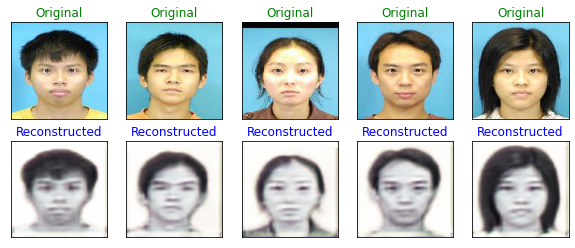

time: 1.73 s (started: 2023-03-08 23:32:02 +00:00)


In [ ]:
generated_sketches = transfer_ae.predict(cuhk_photo_test)
preparation.plot_side_by_side(cuhk_photo_test, generated_sketches, TARGET_SIZE)

save_images(generated_sketches, model_name='wtae_mse')

## Model Evaluation

In [ ]:
# transfer_ae.save(f'{MODELS_PATH}transfer_face_to_sketch')

time: 442 µs (started: 2023-03-08 23:32:03 +00:00)


/usr/local/lib/python3.9/dist-packages/image_similarity_measures/quality_metrics.py:197: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return structural_similarity(org_img, pred_img, data_range=max_p, multichannel=True)


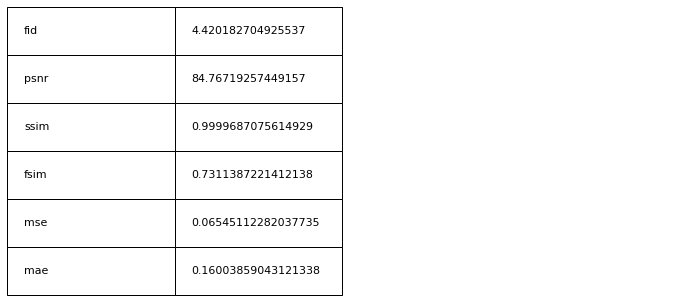

time: 8.83 s (started: 2023-03-08 23:43:10 +00:00)


In [ ]:
transfer_ae_eval.evaluate_batch_on_all(cuhk_sketch_test,generated_sketches)
preparation.plot_dict_as_table(transfer_ae_eval.results)

# Sketch Synthesis III - Coupled Autoencoders

We extend the above approach by using coupled autoencoders. In this approach, we use two autoencoders for photos and sketches and use their encoder and decoder (respectively) in a new model whose added layers (embedding layers) learn the latent distribution of the sketches (target domain) from that of the photos (source domain). Because each latent input is sufficiently expressive of its original value, it suffices to match the latent inputs $h$ of the sources to the latent inputs $z$ of the target.

The coupled autoencoder model (CpAE model) is therefore comprised of three submodels: a source autoencoder with distribution $p_{\theta_s}(y)$, a target autoencoder with distribution $p_{\theta_s}(x)$ and an embedding network which defines the conditional distribution of the latent target domain conditoned on the latent source domain. Here, $\theta_s, \theta_t$ are the parameters of the respective models.
Specifically, we denote by $p(h | y)$ the encoding distribution of the CpAE and $q(z | x )$ the decoding distribution of the CpAE, both of which correspond to the encoder and decoder of the source and target autoencoders, respectively. The encoder of the target autoencoder defines the prior distribution of the latent samples, $p(z)$. The embedding network whose distribution is denoted by $p(h |z)$ hence defines an aggregated posterior distribution $q(z)$ of the latent targets $z$, and matches it to the prior $p(z)$. 
The Kullback-Leiber divergence is used to measure the distance between the prior and posterior distributions on the latent targets. The objective of the CpAE is therefore regularised by KL Divergence between the two distributions scaled by a divergence factor $\kappa \in [0,1]$, and the total loss $\mathbb{L}$ is given by
$$\mathbb{L}(y,x) = \kappa D_{KL}(q(z) || p(z) ) + (1-\kappa)\mathcal{L}(y,x) .$$




## Training via layer-freezing: CpAE-MSE

Before testing the regularised loss, let us have a model without the KL divergence ($\kappa=0)$

In [22]:
# First fetch the autoencoders
source_autoencoder = keras.models.load_model(f'{MODELS_PATH}face_autoencoder')
target_autoencoder = keras.models.load_model(f'{MODELS_PATH}sketch_autoencoder')

source_autoencoder.encoder.trainable = False
target_autoencoder.decoder.trainable = False

# Create the embedding network
coupledAE_model = keras.Sequential([
    layers.Input(IMG_DIM),
    source_autoencoder.encoder,
    layers.Conv2D(32, 3, strides=1, padding='same'),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.3),
    layers.Conv2D(16, 3, strides=1, padding='same'),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.3),
    layers.Conv2D(32, 3, strides=1, padding='same'),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.3),
    layers.Conv2D(16, 3, strides=1, padding='same'),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.3),
    target_autoencoder.decoder
])

coupledAE_model.summary()

coupledAE_model.compile(
    keras.optimizers.Adam(0.005),
    keras.losses.mse
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_19 (Functional)       (None, 32, 32, 16)        14768     
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 16)       64        
 hNormalization)                                      

### Initial Training via layer-freezing

Epoch 1/100
6/6 [==============================] - ETA: 0s - loss: 0.2575

1/1 [==============================] - 0s 260ms/step


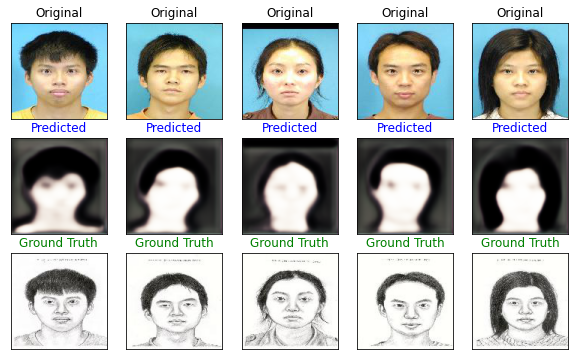

6/6 [==============================] - 11s 2s/step - loss: 0.2575 - val_loss: 0.3654
Epoch 2/100
6/6 [==============================] - 13s 2s/step - loss: 0.1308 - val_loss: 0.2458
Epoch 3/100
6/6 [==============================] - 7s 1s/step - loss: 0.1144 - val_loss: 0.2046
Epoch 4/100
6/6 [==============================] - 8s 1s/step - loss: 0.0904 - val_loss: 0.6052
Epoch 5/100
6/6 [==============================] - 6s 981ms/step - loss: 0.0725 - val_loss: 0.6099
Epoch 6/100
6/6 [==============================] - 8s 1s/step - loss: 0.0610 - val_loss: 0.6697
Epoch 7/100
6/6 [==============================] - 6s 981ms/step - loss: 0.0536 - val_loss: 0.6608
Epoch 8/100
6/6 [==============================] - 8s 1s/step - loss: 0.0511 - val_loss: 0.6458
Epoch 9/100
6/6 [==============================] - 6s 968ms/step - loss: 0.0484 - val_loss: 0.5785
Epoch 10/100
6/6 [==============================] - 9s 2s/step - loss: 0.0457 - val_loss: 0.4241
Epoch 11/100
6/6 [======================

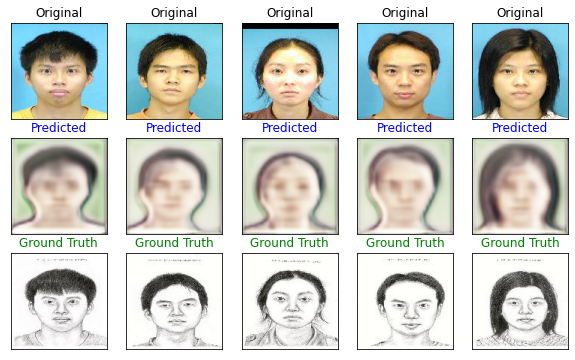

6/6 [==============================] - 8s 1s/step - loss: 0.0436 - val_loss: 0.0684
Epoch 22/100
6/6 [==============================] - 7s 1s/step - loss: 0.0423 - val_loss: 0.0618
Epoch 23/100
6/6 [==============================] - 7s 1s/step - loss: 0.0416 - val_loss: 0.0671
Epoch 24/100
6/6 [==============================] - 6s 991ms/step - loss: 0.0425 - val_loss: 0.0570
Epoch 25/100
6/6 [==============================] - 9s 1s/step - loss: 0.0415 - val_loss: 0.0571
Epoch 26/100
6/6 [==============================] - 6s 1s/step - loss: 0.0416 - val_loss: 0.0602
Epoch 27/100
6/6 [==============================] - 8s 1s/step - loss: 0.0416 - val_loss: 0.0601
Epoch 28/100
6/6 [==============================] - 6s 994ms/step - loss: 0.0412 - val_loss: 0.0584
Epoch 29/100
6/6 [==============================] - 8s 1s/step - loss: 0.0416 - val_loss: 0.0586
Epoch 30/100
6/6 [==============================] - 6s 991ms/step - loss: 0.0415 - val_loss: 0.0546
Epoch 31/100
6/6 [================

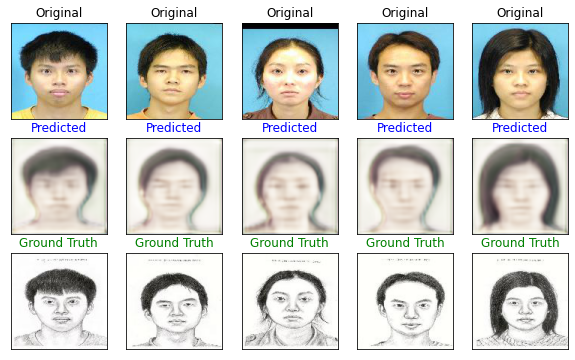

6/6 [==============================] - 9s 2s/step - loss: 0.0402 - val_loss: 0.0497
Epoch 42/100
6/6 [==============================] - 6s 940ms/step - loss: 0.0402 - val_loss: 0.0515
Epoch 43/100
6/6 [==============================] - 7s 1s/step - loss: 0.0402 - val_loss: 0.0493
Epoch 44/100
6/6 [==============================] - 7s 1s/step - loss: 0.0398 - val_loss: 0.0477
Epoch 45/100
6/6 [==============================] - 7s 1s/step - loss: 0.0394 - val_loss: 0.0440
Epoch 46/100
6/6 [==============================] - 7s 1s/step - loss: 0.0393 - val_loss: 0.0435
Epoch 47/100
6/6 [==============================] - 7s 1s/step - loss: 0.0393 - val_loss: 0.0470
Epoch 48/100
6/6 [==============================] - 7s 1s/step - loss: 0.0400 - val_loss: 0.0454
Epoch 49/100
6/6 [==============================] - 6s 980ms/step - loss: 0.0405 - val_loss: 0.0452
Epoch 50/100
6/6 [==============================] - 8s 1s/step - loss: 0.0395 - val_loss: 0.0457
Epoch 51/100
6/6 [===================

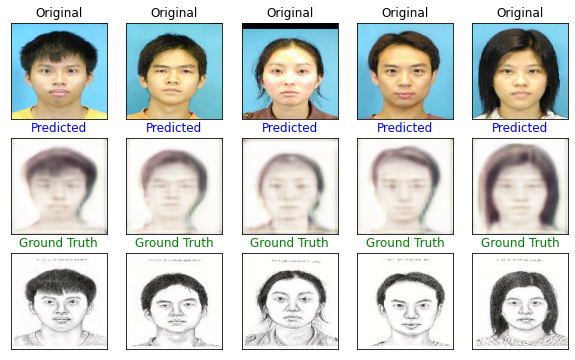

6/6 [==============================] - 7s 1s/step - loss: 0.0409 - val_loss: 0.0447
Epoch 62/100
6/6 [==============================] - 8s 1s/step - loss: 0.0407 - val_loss: 0.0512
Epoch 63/100
6/6 [==============================] - 6s 1s/step - loss: 0.0401 - val_loss: 0.0538
Epoch 64/100
6/6 [==============================] - 8s 1s/step - loss: 0.0397 - val_loss: 0.0461
Epoch 65/100
6/6 [==============================] - 6s 996ms/step - loss: 0.0388 - val_loss: 0.0526
Epoch 66/100
6/6 [==============================] - 8s 1s/step - loss: 0.0397 - val_loss: 0.0508
Epoch 67/100
6/6 [==============================] - 6s 1s/step - loss: 0.0394 - val_loss: 0.0503
Epoch 68/100
6/6 [==============================] - 8s 1s/step - loss: 0.0391 - val_loss: 0.0494
Epoch 69/100
6/6 [==============================] - 6s 986ms/step - loss: 0.0385 - val_loss: 0.0514
Epoch 70/100
6/6 [==============================] - 9s 1s/step - loss: 0.0390 - val_loss: 0.0485
Epoch 71/100
6/6 [===================

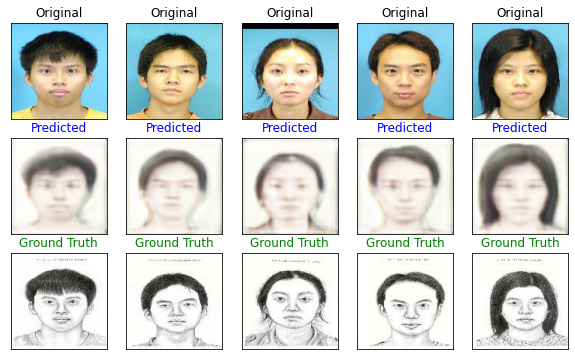

6/6 [==============================] - 9s 1s/step - loss: 0.0379 - val_loss: 0.0453
Epoch 82/100
6/6 [==============================] - 7s 1s/step - loss: 0.0379 - val_loss: 0.0457
Epoch 83/100
6/6 [==============================] - 7s 1s/step - loss: 0.0377 - val_loss: 0.0450
Epoch 84/100
6/6 [==============================] - 7s 1s/step - loss: 0.0376 - val_loss: 0.0462
Epoch 85/100
6/6 [==============================] - 8s 1s/step - loss: 0.0370 - val_loss: 0.0426
Epoch 86/100
6/6 [==============================] - 6s 1s/step - loss: 0.0382 - val_loss: 0.0455
Epoch 87/100
6/6 [==============================] - 8s 1s/step - loss: 0.0387 - val_loss: 0.0489
Epoch 88/100
6/6 [==============================] - 6s 1s/step - loss: 0.0376 - val_loss: 0.0403
Epoch 89/100
6/6 [==============================] - 8s 1s/step - loss: 0.0375 - val_loss: 0.0460
Epoch 90/100
6/6 [==============================] - 6s 1s/step - loss: 0.0375 - val_loss: 0.0443
Epoch 91/100
6/6 [=========================

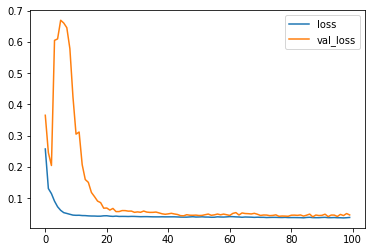

time: 12min 24s (started: 2023-03-09 11:54:40 +00:00)


In [23]:
# Train the new layers only
coupledAE_model.fit(
    cuhk_photo_train, cuhk_sketch_train,
    epochs=100, batch_size=32, 
    validation_data=(cuhk_photo_test, cuhk_sketch_test),
    callbacks=[
        ModelVizCallback(coupledAE_model, cuhk_photo_test, cuhk_sketch_test, TARGET_SIZE, freq=20),
    ],
)

plt.plot(coupledAE_model.history.history["loss"])
plt.plot(coupledAE_model.history.history["val_loss"])
plt.legend(['loss', 'val_loss'], loc='upper right')

1/1 [==============================] - 0s 290ms/step


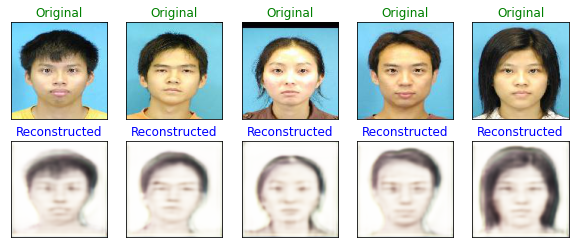

time: 857 ms (started: 2023-03-09 12:07:04 +00:00)


In [24]:
generated_sketches = coupledAE_model.predict(cuhk_photo_test)
preparation.plot_side_by_side(cuhk_photo_test, generated_sketches, TARGET_SIZE)

### Fine Tuning the model

Finally, we fine tune the entire end-to-end model. For this, we assemble the embedding network defined and trained above with the decoder of the trained target autoencoder and train it with a low learning rate.

Epoch 1/20
6/6 [==============================] - 15s 2s/step - loss: 0.0519 - val_loss: 0.0455
Epoch 2/20
6/6 [==============================] - 10s 2s/step - loss: 0.0504 - val_loss: 0.0448
Epoch 3/20
6/6 [==============================] - 11s 2s/step - loss: 0.0492 - val_loss: 0.0443
Epoch 4/20
6/6 [==============================] - 11s 2s/step - loss: 0.0480 - val_loss: 0.0438
Epoch 5/20
6/6 [==============================] - 11s 2s/step - loss: 0.0473 - val_loss: 0.0435
Epoch 6/20
6/6 [==============================] - 9s 2s/step - loss: 0.0461 - val_loss: 0.0432
Epoch 7/20
6/6 [==============================] - 11s 2s/step - loss: 0.0453 - val_loss: 0.0429
Epoch 8/20
6/6 [==============================] - 12s 2s/step - loss: 0.0448 - val_loss: 0.0427
Epoch 9/20
6/6 [==============================] - 10s 2s/step - loss: 0.0442 - val_loss: 0.0425
Epoch 10/20
6/6 [==============================] - 10s 1s/step - loss: 0.0434 - val_loss: 0.0424
Epoch 11/20
6/6 [=======================

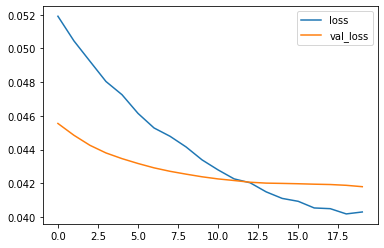

time: 4min 24s (started: 2023-03-09 12:07:05 +00:00)


In [25]:
coupledAE_model.trainable = True
coupledAE_model.compile(
    keras.optimizers.Adam(0.00001),
    keras.losses.mse
)
coupledAE_model.fit(
    cuhk_photo_train, cuhk_sketch_train,
    batch_size=32, epochs=20, 
    validation_data=(cuhk_photo_test, cuhk_sketch_test),
)

# plt.plot(coupledAE_model.history.history["loss"])
# plt.plot(coupledAE_model.history.history["val_loss"])
# plt.legend(['loss', 'val_loss'], loc='upper right')

In [ ]:
coupledAE_model.save(f'{MODELS_PATH}coupled_autoencoder')

time: 4.99 s (started: 2023-03-06 20:15:18 +00:00)


### Model Evaluation

1/1 [==============================] - 1s 504ms/step


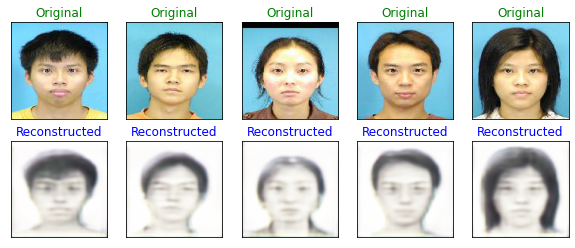

time: 1.08 s (started: 2023-03-09 12:11:30 +00:00)


In [26]:
generated_sketches = coupledAE_model.predict(cuhk_photo_test)
preparation.plot_side_by_side(cuhk_photo_test, generated_sketches, TARGET_SIZE)

save_images(generated_sketches, model_name='cpae_mse')

/usr/local/lib/python3.9/dist-packages/image_similarity_measures/quality_metrics.py:197: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return structural_similarity(org_img, pred_img, data_range=max_p, multichannel=True)


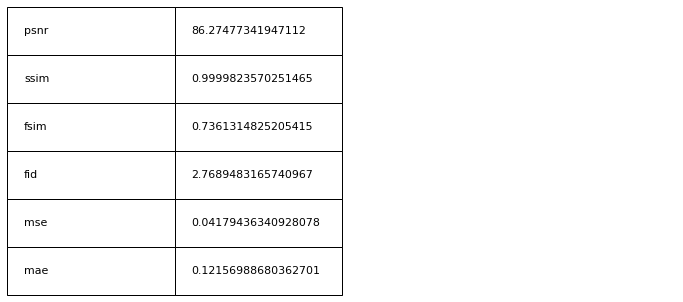

time: 7.92 s (started: 2023-03-09 12:11:31 +00:00)


In [27]:
coupledAE_eval = similarity.Evaluator('coupled_autoencoders')
coupledAE_eval.evaluate_batch_on_all(cuhk_sketch_test,generated_sketches)
preparation.plot_dict_as_table(coupledAE_eval.results)

## Training using KL-Divergence: CpAE-KL

In [ ]:
class CoupledAE(Model):

    def __init__(self, source_autoencoder, target_autoencoder, embedding_layers, **kwargs):
        super(CoupledAE, self).__init__(**kwargs)
        self.source_autoencoder = source_autoencoder
        self.target_autoencoder = target_autoencoder
        self.embedding_network = embedding_layers

        self.kl_loss_tracker = keras.metrics.Mean(name='kl_loss')
        self.rec_loss_tracker = keras.metrics.Mean(name='reconstruction_loss')
        self.total_loss_tracker = keras.metrics.Mean(name='total_loss')

    def call(self, inputs):
        source_latent = self.source_autoencoder.encoder(inputs)
        return target_autoencoder.decoder(self.embedding_network(source_latent))

    def train_step(self, data):
        
        inputs, outputs = data

        with tf.GradientTape() as tape:

            latent_targets = self.target_autoencoder.decoder(outputs)
            embedded_targets = self.embedding_network(self.source_autoencoder.encoder(inputs))
            generated_outputs = self.target_autoencoder.decoder(embedded_targets)

            kl_loss = keras.losses.kl_divergence(latent_targets, embedded_targets)
            reconstruction_loss = self.loss(outputs, generated_outputs)
            total_loss=  tf.reduce_mean(kl_loss+reconstruction_loss)
        grads = tape.gradient(total_loss, self.embedding_network.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.embedding_network.trainable_variables))

        self.kl_loss_tracker.update_state(kl_loss)
        self.rec_loss_tracker.update_state(reconstruction_loss)
        self.total_loss_tracker.update_state(total_loss)

        return {
            "total_loss": self.total_loss_tracker.result(),
            "rec_loss": self.rec_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
        


time: 5.85 ms (started: 2023-03-08 00:28:38 +00:00)


In [13]:
# First fetch the autoencoders
source_autoencoder = keras.models.load_model(f'{MODELS_PATH}face_autoencoder')
target_autoencoder = keras.models.load_model(f'{MODELS_PATH}sketch_autoencoder')

source_autoencoder.encoder.trainable = False
target_autoencoder.decoder.trainable = False

# Create the embedding network
embedding_network = keras.Sequential([
    layers.Input(IMG_DIM),
    source_autoencoder.encoder,
    layers.Conv2D(32, 3, strides=1, padding='same'),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.3),
    layers.Conv2D(16, 3, strides=1, padding='same'),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.3),
    layers.Conv2D(32, 3, strides=1, padding='same'),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.3),
    layers.Conv2D(16, 3, strides=1, padding='same'),
    # target_autoencoder.decoder
], name='embedding_network')

# embedding_network.summary()

# embedding_network.compile(
#     keras.optimizers.Adam(0.001),
#     loss=keras.losses.kl_divergence
# )

time: 2.94 s (started: 2023-03-09 11:30:39 +00:00)


### Initial Training with a double objective

Epoch 1/100
5/5 [==============================] - 10s 2s/step - loss: 0.3429 - embedding_network_loss: 51.8175 - model_3_loss: 0.3424 - val_loss: 0.2212 - val_embedding_network_loss: 50.2380 - val_model_3_loss: 0.2207
Epoch 2/100
5/5 [==============================] - 9s 2s/step - loss: 0.0744 - embedding_network_loss: 34.7921 - model_3_loss: 0.0741 - val_loss: 0.0766 - val_embedding_network_loss: 42.5258 - val_model_3_loss: 0.0762
Epoch 3/100
5/5 [==============================] - 7s 1s/step - loss: 0.0684 - embedding_network_loss: 30.3767 - model_3_loss: 0.0681 - val_loss: 0.0748 - val_embedding_network_loss: 36.7541 - val_model_3_loss: 0.0745
Epoch 4/100
5/5 [==============================] - 8s 2s/step - loss: 0.0632 - embedding_network_loss: 29.4747 - model_3_loss: 0.0629 - val_loss: 0.0770 - val_embedding_network_loss: 36.0639 - val_model_3_loss: 0.0766
Epoch 5/100
5/5 [==============================] - 7s 2s/step - loss: 0.0578 - embedding_network_loss: 29.8580 - model_3_loss: 

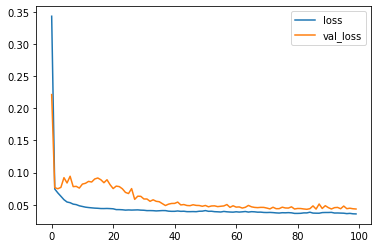

time: 13min 20s (started: 2023-03-09 11:30:50 +00:00)


In [14]:
input_img = layers.Input(IMG_DIM)
coupledAE_KL_model = Model(input_img, [embedding_network(input_img),
                           target_autoencoder.decoder(embedding_network(input_img))],
                           name='coupled_AE_KL')

kl_factor = 0.00001
coupledAE_KL_model.compile(
    optimizer=keras.optimizers.Adam(0.0025), 
    loss=[keras.losses.kl_divergence, keras.losses.mse],
    loss_weights=[kl_factor, 1-kl_factor]
)

coupledAE_KL_model.fit(
    cuhk_photo_train, [target_autoencoder.encoder(cuhk_sketch_train), cuhk_sketch_train],
    batch_size=32, epochs=100, validation_split=0.1
)

plt.plot(coupledAE_KL_model.history.history["loss"])
plt.plot(coupledAE_KL_model.history.history["val_loss"])
plt.legend(['loss', 'val_loss'], loc='upper right')


1/1 [==============================] - 1s 611ms/step


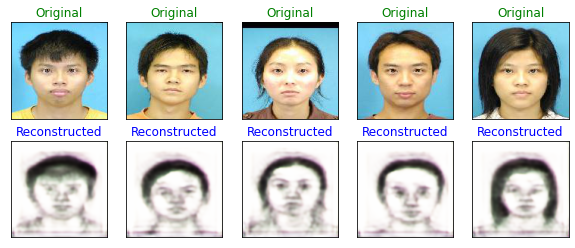

time: 1.18 s (started: 2023-03-09 11:44:11 +00:00)


In [15]:
_, generated_sketches = coupledAE_KL_model.predict(cuhk_sketch_test)
preparation.plot_side_by_side(cuhk_photo_test, generated_sketches, TARGET_SIZE)

### Fine Tuning the model

We now fine tune the entire model, using the standard MSE as its loss.

In [16]:
target_autoencoder.trainable = True
embedding_network.trainable=True

final_coupled_AEKL = keras.Sequential([
    layers.Input(IMG_DIM),
    embedding_network,
    target_autoencoder.decoder,
])

final_coupled_AEKL.compile(
    keras.optimizers.Adam(0.0001),
    keras.losses.mse
)

final_coupled_AEKL.fit(
    cuhk_photo_train, cuhk_sketch_train,
    batch_size=32, epochs=20, validation_split=0.1
)

Epoch 1/20
5/5 [==============================] - 19s 3s/step - loss: 0.0532 - val_loss: 0.0454
Epoch 2/20
5/5 [==============================] - 9s 2s/step - loss: 0.0517 - val_loss: 0.0489
Epoch 3/20
5/5 [==============================] - 10s 2s/step - loss: 0.0503 - val_loss: 0.0523
Epoch 4/20
5/5 [==============================] - 10s 2s/step - loss: 0.0491 - val_loss: 0.0550
Epoch 5/20
5/5 [==============================] - 9s 2s/step - loss: 0.0482 - val_loss: 0.0566
Epoch 6/20
5/5 [==============================] - 10s 2s/step - loss: 0.0474 - val_loss: 0.0573
Epoch 7/20
5/5 [==============================] - 10s 2s/step - loss: 0.0464 - val_loss: 0.0578
Epoch 8/20
5/5 [==============================] - 9s 2s/step - loss: 0.0458 - val_loss: 0.0580
Epoch 9/20
5/5 [==============================] - 10s 2s/step - loss: 0.0450 - val_loss: 0.0581
Epoch 10/20
5/5 [==============================] - 11s 2s/step - loss: 0.0446 - val_loss: 0.0582
Epoch 11/20
5/5 [=========================

time: 3min 24s (started: 2023-03-09 11:44:47 +00:00)


### Model Evaluation

1/1 [==============================] - 0s 292ms/step


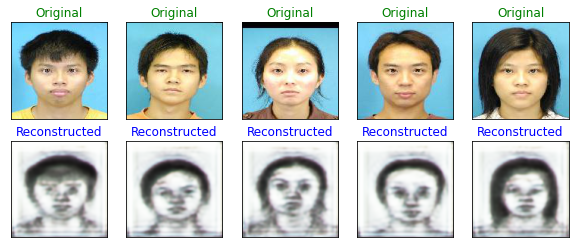

time: 6.42 s (started: 2023-03-09 11:51:59 +00:00)


In [21]:
generated_sketches = final_coupled_AEKL.predict(cuhk_sketch_test)
preparation.plot_side_by_side(cuhk_photo_test, generated_sketches, TARGET_SIZE)

save_images(generated_sketches, model_name='cpae_kl')

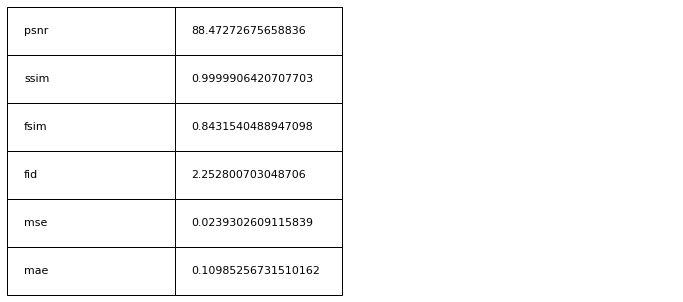

{'psnr': 88.47272675658836,
 'ssim': 0.9999906420707703,
 'fsim': 0.8431540488947098,
 'fid': 2.252800703048706,
 'mse': 0.0239302609115839,
 'mae': 0.10985256731510162}

time: 355 ms (started: 2023-03-09 11:51:37 +00:00)


In [20]:
coupledAEKL_eval = similarity.Evaluator('coupled_autoencoders_regularised')
coupledAEKL_eval.evaluate_batch_on_all(cuhk_sketch_test,generated_sketches)
preparation.plot_dict_as_table(coupledAEKL_eval.results)
coupledAEKL_eval.results